In [69]:
import pandas as pd
import pyodbc 
import numpy as np
import os
from os import listdir, path
from os.path import isfile, join, isdir
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
warnings.filterwarnings('ignore')

##Define Data Reading Function for Channel Data
def readChannelData(file, sheet, channel):
    
    channelData_all = pd.read_excel(io=file,sheet_name=sheet)
    if len(channelData_all) > 0:
        ChannelRawStart = channelData_all[channelData_all['Sample ID']=='Raw'].index.values[0] + 1
        ChannelRawEnd = channelData_all[channelData_all['Sample ID']=='Normalized'].index.values[0] - 2
        ChannelRaw = channelData_all.loc[ChannelRawStart:ChannelRawEnd]
        ChannelRaw['Processing Step'] = 'Raw'

        ChannelNormStart = channelData_all[channelData_all['Sample ID']=='Normalized'].index.values[0] + 1
        ChannelNormEnd = channelData_all[channelData_all['Sample ID']=='SecondDerivative'].index.values[0] - 2
        ChannelNorm = channelData_all.loc[ChannelNormStart:ChannelNormEnd]
        ChannelNorm['Processing Step'] = 'Normalized'

        Channel2ndStart = channelData_all[channelData_all['Sample ID']=='SecondDerivative'].index.values[0] + 1

        if 'Modulated' in channelData_all['Sample ID'].unique():
            Channel2ndEnd = channelData_all[channelData_all['Sample ID']=='Modulated'].index.values[0] - 2
            ChannelModulatedStart = channelData_all[channelData_all['Sample ID']=='Modulated'].index.values[0] + 1
            ChannelModulated = channelData_all.loc[ChannelModulatedStart:ChannelModulatedStart+len(ChannelRaw)]
            ChannelModulated['Processing Step'] = 'Modulated'
            Channel2nd = channelData_all.loc[Channel2ndStart:Channel2ndEnd]
            Channel2nd['Processing Step'] = '2nd'

            if len(ChannelRaw) == len(ChannelNorm) and len(ChannelRaw) == len(Channel2nd) and len(ChannelRaw) == len(ChannelModulated):

                ChannelFinal = pd.concat([ChannelRaw, ChannelNorm, Channel2nd, ChannelModulated],axis=0)
                ChannelFinal['Channel'] = channel
                ChannelFinal.set_index(['Test Guid', 'Replicate Number'],inplace=True)
            else:
                print("Error in parsing Datablocks")
        else:
            Channel2nd = channelData_all.loc[Channel2ndStart:Channel2ndStart+len(ChannelRaw)]
            Channel2nd['Processing Step'] = '2nd'
            #if len(ChannelRaw) == len(ChannelNorm) and len(ChannelRaw) == len(Channel2nd):
            print("Im in the right block")
            ChannelFinal = pd.concat([ChannelRaw, ChannelNorm, Channel2nd],axis=0)
            ChannelFinal['Channel'] = channel
            ChannelFinal.set_index(['Test Guid', 'Replicate Number'],inplace=True)
                
            #else:
            #print("Error in parsing Datablocks")
              
        
    
    else:
        ChannelFinal = pd.DataFrame()
    
    
    
    return ChannelFinal
    
def readRawData(file, environment):
    channelDict = {'Green_470_510':'Green',
                   'Yellow_530_555':'Yellow',
                   'Orange_585_610':'Orange',
                   'Red_625_660':'Red',
                   'Far_Red_680_715':'Far_Red'}
    
    Summary_Tab = pd.read_excel(io=file,sheet_name='Summary',header=2)
    COC_Tab = pd.read_excel(io=file,sheet_name='Chain of Custody')
    Summary_COC_Data = Summary_Tab.set_index(['Test Guid', 'Replicate Number']).join(COC_Tab.set_index(['Test Guid', 'Replicate Number']).loc[:, [x for x in COC_Tab.columns if x not in Summary_Tab.columns]])
    
    Summary_COC_Data['Environment'] = environment
    
    channelDataDict = {}
    for channel in channelDict:
        channelDataDict[channel] = readChannelData(file, channel, channelDict[channel])
    channelDataFinal = pd.concat([channelDataDict[df] for df in channelDataDict if len(channelDataDict[df])>0],axis=0)
    
    channelDataFinal['Environment'] = environment
    channelDataFinal.set_index(['Target Result Guid', 'Processing Step', 'Channel', 'Environment'],append=True,inplace=True)
    for i in range(1,256):
        if "Readings "+ str(i) not in channelDataFinal.columns:
            channelDataFinal["Readings "+str(i)] = np.nan
    channelDataFinal_readings = channelDataFinal.loc[:, ['Readings '+str(i) for i in range(1,256)]]
    channelDataFinal_summary = channelDataFinal.swaplevel(3,0).swaplevel(3,1).swaplevel(3,2)
    channelDataFinal_summary = channelDataFinal_summary.loc['Raw'].drop(['Readings '+str(i) for i in range(1,256)],axis=1)
    
    return Summary_COC_Data, channelDataFinal_summary, channelDataFinal_readings

def getMainDirectories(parentFolder, filter_date=None):
    dirList = []
    #initalize dirList
    dirList = [f for f in listdir(parentFolder) if isdir(join(parentFolder, f))]
    print("Raw folder list length:", len(dirList))
    if filter_date != None:
        filter_date = datetime.datetime.strptime(filter_date,"%Y-%m-%d")
        for folder in dirList:
            target = parentFolder+'//'+folder
            try:
                mtime = os.path.getmtime(target)
            except OSError:
                mtime = 0
            last_modified_date = datetime.datetime.fromtimestamp(mtime)
            if last_modified_date < filter_date:
                dirList.remove(folder)
    print("Filtered folder list length:", len(dirList))
    return dirList
def getDirectories(parentFolder):
    level = 0
    dirList = []
    #initalize dirList
    dirList = [f for f in listdir(parentFolder) if isdir(join(parentFolder, f))]     
    lengthChange = len(dirList)
    
    while lengthChange > 0:
        lengthInitial = len(dirList)
        
        for folder in dirList:
            
            try:
                sublist = [folder+"/"+f for f in listdir(parentFolder+"/"+folder) if isdir(join(parentFolder+"/"+folder, f))]
                addlist = [x for x in sublist if x not in dirList]
                
                dirList = dirList+addlist
            except:
                print("couldn't find:", folder, "most have been moved!")
                
        lengthEnd = len(dirList)
        lengthChange = lengthEnd - lengthInitial
        
    return dirList
             
def getFiles(parentFolder, subFolders):
    targetFiles = []
    for folder in subFolders:
        #print(folder)
        targetFiles = targetFiles + [(parentFolder+"/"+folder+"/"+f) for f in listdir(parentFolder+"/"+folder) if isfile(join(parentFolder+"/"+folder, f)) and "RawDataExport" in f and ".xlsx" in f]
        
    return targetFiles 

In [70]:
##Step 1 - Open & Read Import Tracker Document:
import_tracker = pd.read_csv('C:/Users/RipleyA/OneDrive - QIAGEN GmbH/Documents/NMDX_Data_Lake_Importer_Tracker_2.csv').set_index('filepath')

##Step 2 Find Files in Import Directories
import urllib
import sqlalchemy as sa

connection_string = (
    'Driver={ODBC Driver 17 for SQL Server};'
    'SERVER=ABR-RIPLEYA-D1;'
    'Database=neumodxRawDataDB;'
    'Trusted_Connection=Yes;'
)

connection_uri = f"mssql+pyodbc:///?odbc_connect={urllib.parse.quote_plus(connection_string)}"
engine = sa.create_engine(connection_uri, fast_executemany=True)

summary_coc_header = pd.read_excel('C:/Users/RipleyA/OneDrive - QIAGEN GmbH/Desktop/temp_file.xlsx', sheet_name='summary_coc')
channels_summary_header = pd.read_excel('C:/Users/RipleyA/OneDrive - QIAGEN GmbH/Desktop/temp_file.xlsx', sheet_name='channels_summary')
channels_readings_header = pd.read_excel('C:/Users/RipleyA/OneDrive - QIAGEN GmbH/Desktop/temp_file.xlsx', sheet_name='channels_readings')

def scrapeFiles(directory, env, filter_date=None):
    parentDirs = {}
    i = 0
    system_error_list_288 = [] 
    for folder in [x for x in getMainDirectories(directory, filter_date) if 'N16' not in x and 'V334' not in x]:
        print(folder)
        try:
            parentDirs[env] = directory+"/"+folder

            files = {}
            for parent in parentDirs:
                parentDir = parentDirs[parent]
                file_list = getFiles(parentDir, getDirectories(parentDir))
                for file in file_list:
                    if file not in import_tracker.index.unique(0) and '~' not in file:
                        try:
                            files[file] = parent
                        except:
                            print(file, ' moved try again later')
                print("Found "+str(len(files))+" for import")


            ##Step 3 Parse Data from files in queue for import:


            i = 0
            for file in files:
                if "~" not in file and file not in import_tracker.index.unique(0).tolist():
                    i+=1
                    time = pd.Timestamp.now()
                    try:
                        readData_COC, readData_Channel_summary, readData_Channel_readings = readRawData(file, files[file])
                        channel_summary = pd.concat([channels_summary_header, readData_Channel_summary.reset_index()])
                        channel_readings = pd.concat([channels_readings_header, readData_Channel_readings.reset_index()])
                        summary_coc = pd.concat([summary_coc_header, readData_COC.reset_index()])

                        for col in channel_summary.columns:
                            if 'Barcode' in col:
                                channel_summary[col] = channel_summary[col].str.replace("_x001D_", " ")
                        channel_summary = channel_summary.astype(object).where(pd.notna(channel_summary), None)


                        for col in summary_coc.columns:
                            if 'Barcode' in col:
                                summary_coc[col] = summary_coc[col].astype(str)
                                summary_coc[col] = summary_coc[col].str.replace("_x001D_", " ")
                        summary_coc = summary_coc.astype(object).where(pd.notna(summary_coc), None)
                        for col in summary_coc.loc[:, [col for col in summary_coc if 'Date' in col]].columns:
                            summary_coc.loc[:, col] = summary_coc.loc[:, col].astype(str)
                            summary_coc.loc[:, col] = summary_coc.loc[:, col].str.replace(' -04:00','').replace(' -05:00','')
                            try:
                                summary_coc.loc[:, col] = summary_coc.loc[:, col].astype('datetime64[ns]')
                            except:
                                summary_coc.loc[:, col] = np.nan
                        #summary_coc.loc[:, [col for col in summary_coc if 'Date' in col]] = pd.to_datetime(summary_coc.loc[:, [col for col in summary_coc if 'Date' in col]])
                        print("Starting Processing of :", folder, file)
                        print('Read Successful')

                        channel_readings = channel_readings.astype(object).where(pd.notna(channel_readings), None)

                        channel_summary['Import Time'] = time
                        channel_readings['Import Time'] = time
                        summary_coc['Import Time'] = time
                        channel_summary['File source'] = file
                        channel_readings['File source'] = file
                        summary_coc['File source'] = file

                        channel_summary.to_sql("channel_summary", engine, schema="dbo", if_exists="append", index=False)
                        print('Channel Summary Imported Successfully')
                        summary_coc.to_sql("summary_coc", engine, schema="dbo", if_exists="append", index=False)
                        print('Summary / COC Imported Successfully')
                        channel_readings.to_sql("channel_readings", engine, schema="dbo", if_exists="append", index=False)
                        print('Channel Readings Imported Successfully')
                        print("--"*30)

                        import_tracker.loc[file, 'import_date'] = time
                        import_tracker.loc[file, 'status'] = 'successful'

                    except:
                        print(i, file)
                        print('Read Unsuccessful')
                        print("--"*30)
                        import_tracker.loc[file, 'import_date'] = time
                        import_tracker.loc[file, 'status'] = 'unsuccessful'

            import_tracker.to_csv('C:/Users/RipleyA/OneDrive - QIAGEN GmbH/Documents/NMDX_Data_Lake_Importer_Tracker_2.csv')
        except:
            print("Error Processing "+folder)
            system_error_list_288.append(folder)

        print("**"*40)


In [71]:
scrapeFiles('T:/System Characterization/Module Qualification PSG', 'V&V_Mod_Qual', '2018-01-01')

Raw folder list length: 19
Filtered folder list length: 19
96000003
Found 2 for import
Starting Processing of : 96000003 T:/System Characterization/Module Qualification PSG/96000003/Iteration #4 V1263 1178/V1178/HCV/RawDataExport.96-3.96000003.2205261143.44861DF0.xlsx
Read Successful
Channel Summary Imported Successfully
Summary / COC Imported Successfully
Channel Readings Imported Successfully
------------------------------------------------------------
Starting Processing of : 96000003 T:/System Characterization/Module Qualification PSG/96000003/Iteration #4 V1263 1178/V1263/HCV/RawDataExport.96-3.96000003.2205261143.F0E70302.xlsx
Read Successful
Channel Summary Imported Successfully
Summary / COC Imported Successfully
Channel Readings Imported Successfully
------------------------------------------------------------
********************************************************************************
96000005
Found 0 for import
************************************************************

In [72]:
##Step 2: Query Database to Retrieve Module Qualification Data.
def getneumodxRawDataDBDataAll(environment='', startTime='2000-01-01', endTime='2100-01-01', useserver='ABR-RIPLEYA-D1', db='neumodxRawDataDB'):
    """
    Returns a Combined DataFrame of all DataFields Available in the three datatables in neumodxRawDataDB
    :param environment: str Environment Tag to use for query
    :param startTime: datetime Returns data that has been processed after time specified
    :param endTime: datetime Returns data that has been processed before time specified
    :param useserver: str Name of the Server to use when establishing connection string
    :param db: str Name of the Database to use when establishing connection string
    """

    config = dict(server=useserver,
    port=      1433,
    database=  db,
    )

    conn_str = ('SERVER={server};' +
                'Database={database};' +
                'TRUSTED_CONNECTION=yes')

    conn = pyodbc.connect(
        r'DRIVER={SQL Server};' +
        conn_str.format(**config)
        )



    coc_query = "Select * from [summary_coc] where [Environment] like '%"+environment+"%' And [Start Date/Time]>'"+startTime+"' And [Start Date/Time]< '"+endTime+"'"
    channel_summary_query = "Select * from [channel_summary] where [Environment] like '%"+environment+"%'"
    channel_readings_query = "Select * from [channel_readings] where [Environment] like '%"+environment+"%'"
    
    
    
    print(coc_query)
    coc_summary_data = pd.read_sql(coc_query, conn).drop_duplicates(['Test Guid', 'Replicate Number']).set_index(['Test Guid', 'Replicate Number'])
    print("COC Query Finished")
    print(channel_summary_query)
    channel_summary_data = pd.read_sql(channel_summary_query, conn).drop_duplicates(['Test Guid', 'Replicate Number', 'Target Result Guid']).set_index(['Test Guid', 'Replicate Number', 'Target Result Guid'])
    print("Channel Summary Query Finished")
    print(channel_readings_query)
    channel_readings_data = pd.read_sql(channel_readings_query, conn).drop_duplicates(['Test Guid', 'Replicate Number', 'Target Result Guid', 'Processing Step']).set_index(['Test Guid', 'Replicate Number', 'Target Result Guid', 'Processing Step'])
    print("Channel Readings Query Finished")
    print("Joining DataFrames")
    channel_summary_data = channel_summary_data.loc[:, [x for x in channel_summary_data.columns if x not in coc_summary_data.columns]]
    channel_readings_data = channel_readings_data.loc[:, [x for x in channel_readings_data.columns if x not in coc_summary_data.columns and x not in channel_summary_data.columns]]
    joinFrame = coc_summary_data.join(channel_summary_data).join(channel_readings_data)
    return joinFrame.reset_index()

ModQualData =  getneumodxRawDataDBDataAll(environment='V&V_Mod_Qual')

Select * from [summary_coc] where [Environment] like '%V&V_Mod_Qual%' And [Start Date/Time]>'2000-01-01' And [Start Date/Time]< '2100-01-01'
COC Query Finished
Select * from [channel_summary] where [Environment] like '%V&V_Mod_Qual%'
Channel Summary Query Finished
Select * from [channel_readings] where [Environment] like '%V&V_Mod_Qual%'
Channel Readings Query Finished
Joining DataFrames


In [73]:
##Step 3: Get Consumable Info for ModQualData
def retrieveConsumableLots(data, consumable_types=['Pcr Cartridge', 'Capture Plate', 'Test Strip NeuMoDx', 'Buffer', 'Release Reagent', 'Wash Reagent']):
    """
    Retrieves Lot information for NMDX Consumables from Barcode String
    :param consumable_types: list-like List of Consumables to get Data For.
    """
    
    for consumable_type in consumable_types:
        data[consumable_type+" Lot"] = data[consumable_type+" Barcode"].str[18:24]

    return data

def retrieveConsumableSerials(data, consumable_types=['Pcr Cartridge', 'Capture Plate', 'Test Strip NeuMoDx', 'Buffer', 'Release Reagent', 'Wash Reagent']):
    """
    Retrieves Consumable Serial information for NMDX Consumables from Barcode String
    :param consumable_types: list-like List of Consumables to get Data For
    """
    
    for consumable_type in consumable_types:
        data[consumable_type+" Serial"] = data[consumable_type+" Barcode"].str[27:32]

    return data

ModQualData = retrieveConsumableLots(ModQualData)
ModQualData = retrieveConsumableSerials(ModQualData)

In [87]:
print(ModQualData['Pcr Cartridge Lot'].unique())
BoydFrame = ModQualData[ModQualData['Pcr Cartridge Lot'].isin(['11762X', '107589', '118342', '118857', '220502', '220509', '220510'])]

['191261' '11762X' '107589' '117463' '11592X' '115358' '115430' '220510'
 '' '115422' '118342' '118857' '220509' '111911' '220502' '116607'
 '115355']


In [92]:
##Step 4: Determine "Run Number" Based on Unique Module / Cartridge Barcode Combination
def getRunNumbers(data):
    """
    Assigns a Run Number for each unique Module / Cartridge Serial Combination Found
    """
    data['Start Date/Time'] = data['Start Date/Time'].astype('datetime64[ns]')
    data['End Date/Time'] = data['End Date/Time'].astype('datetime64[ns]')
    data = data.set_index(['PCR Module Serial', 'Pcr Cartridge Barcode']).sort_index()
    
    data_agg = data.drop_duplicates(['Test Guid', 'Replicate Number'])[['Start Date/Time', 'End Date/Time', 'Sample ID']].groupby(level=[0,1]).agg({'Start Date/Time':['min'],
                                                                                                'End Date/Time':['max'],
                                                                                                'Sample ID':['count']})
    data_agg.columns = ['Run Start Time', 'Run End Time', 'Sample Count']
    data_agg['Run Duration (Mins)'] = data_agg['Run End Time'] - data_agg['Run Start Time']
    data_agg['Run Duration (Mins)'] = (data_agg['Run Duration (Mins)']/np.timedelta64(1,'s'))/60
    data_agg['Run Number'] = np.nan
    data_agg.sort_values('Run Start Time',inplace=True)
    for mod in data_agg.index.unique(0):
        data_agg.loc[mod, 'Run Number'] = np.arange(1, len(data_agg.loc[mod, 'Run Number'])+1)
    
    return data.join(data_agg).reset_index()

BoydFrame = getRunNumbers(BoydFrame)


In [93]:
BoydFrameRaw = BoydFrame[BoydFrame['Processing Step']=='Raw']

In [94]:
BoydFrameRaw['Target Amplified'] = np.where(BoydFrameRaw['Localized Result']=='TargetAmplified',1,0)

In [95]:
def getRunStats(data, statList=['Ct', 'End Point Fluorescence', 'Max Peak Height', 'EPR', 'Target Amplified'], aggTypes=['mean', 'std'], calculate_CV=True):
    """
    A Function that Aggregates and calculates statistics for each Run (Unique Module / Cartridge Combination) 

    :param data: DataFrame
    :param statList: List-Like List of Fields to calculate stats for
    :param aggTypes: List-like List of aggregate functions to apply to dataFrame
    :param calculate_CV: bool Whether or not to calculate %CV

    """
    
    data_subset = data[['PCR Module Serial', 'Run Number', 'Target Name', 'Sample ID', 'Result Code']+statList]
    

    ##Check to make sure calculate_CV dependents are availables if calculate_CV is True.
    if calculate_CV:
        if 'mean' not in aggTypes:
            aggTypes.append(['mean'])
        if 'std' not in aggTypes:
            aggTypes.append(['std'])
    

    ##Create Dictionary to be used for aggregate:
    aggSpecs = {'Sample ID': ['count']}

    for stat in statList:
        aggSpecs[stat] = aggTypes
    

    ##Perform Aggregation of DataFrame
    data_agg = data_subset.groupby(['Result Code', 'Target Name', 'PCR Module Serial', 'Run Number']).agg(aggSpecs).sort_index()

    
    if calculate_CV:
        for field in statList:
            data_agg[(field, "%CV")] = data_agg[(field, 'std')] / data_agg[(field, 'mean')]

    ##Clean up Column Names:
    new_columns = []

    for field, stat in data_agg.columns:
        if field == 'Sample ID':
            new_columns.append("Sample Count")
        elif field in statList:
            new_columns.append(field + " " + stat)
    
    data_agg.columns = new_columns

    return data_agg





In [96]:
RunStats_agg = getRunStats(data=BoydFrameRaw)

In [97]:
RunStats_agg

Sample Count    Ct mean  \
Result Code Target Name PCR Module Serial Run Number                            
CTNG        CT          V1008             1.0                   12  32.278334   
                                          2.0                   12  31.996667   
                        V1035             5.0                   12  32.609166   
                                          6.0                   12  33.079167   
                        V1045             6.0                   12  33.136667   
...                                                            ...        ...   
HCV         SPC2        V998              3.0                   12  31.870833   
                                          4.0                   12  29.735000   
                                          5.0                   12  30.345000   
HIV1        HIV-1       V675              1.0                    7  27.597143   
            SPC2        V675              1.0                    7  27.460000   

                                                        Ct std  \
Result Code Target Name PCR Module Serial Run Number             
CTNG        CT          V1008             1.0         0.375689   
                                          2.0         1.590011   
                        V1035             5.0         0.355846   
                                          6.0         0.399146   
                        V1045             6.0         0.399735   
...                                                        ...   
HCV         SPC2        V998              3.0         1.986342   
                                          4.0         1.084138   
                                          5.0         0.490853   
HIV1        HIV-1       V675              1.0         3.389467   
            SPC2        V675              1.0         0.772356   

                                                      End Point Fluorescence mean  \
Result Code Target Name PCR Module Serial Run Number                                
CTNG        CT          V1008             1.0                         8744.833333   
                                          2.0                        10112.666667   
                        V1035             5.0                         5308.666667   
                                          6.0                         5333.000000   
                        V1045             6.0                         6212.333333   
...                                                                           ...   
HCV         SPC2        V998              3.0                         4331.916667   
                                          4.0                         7890.000000   
                                          5.0                         6441.000000   
HIV1        HIV-1       V675              1.0                        37985.000000   
            SPC2        V675              1.0                         4624.571429   

                                                      End Point Fluorescence std  \
Result Code Target Name PCR Module Serial Run Number                               
CTNG        CT          V1008             1.0                        1837.138528   
                                          2.0                        2091.160980   
                        V1035             5.0                        2004.615417   
                                          6.0                        1532.816421   
                        V1045             6.0                        1164.563151   
...                                                                          ...   
HCV         SPC2        V998              3.0                        1100.055822   
                                          4.0                        1954.217211   
                                          5.0                        1771.585525   
HIV1        HIV-1       V675              1.0                        4283.420401   
            SPC2        V67

In [98]:
in_use_mod_status = pd.read_csv('mod_status_inservice.csv')

in_use_mod_status['Mod Serial Number'] = in_use_mod_status['PCR Module Serial'].str.extract('(\d+)').astype(int)

in_use_mod_status.set_index('Mod Serial Number',inplace=True)

RunStats_agg_mod_serial = RunStats_agg.reset_index()

RunStats_agg_mod_serial['Mod Serial Number'] = RunStats_agg_mod_serial['PCR Module Serial'].str.extract('(\d+)').astype(int)

RunStats_agg_mod_serial.set_index(['Mod Serial Number', 'Result Code', ],inplace=True)

for mod in in_use_mod_status.index.unique():
    try:
        in_use_mod_status.loc[mod, 'CTNG Boyd Runs'] = int(len(RunStats_agg_mod_serial.loc[(mod, 'CTNG'), 'Run Number'].unique()))
    except KeyError:
        in_use_mod_status.loc[mod, 'CTNG Boyd Runs'] = 0
    try:
        in_use_mod_status.loc[mod, 'HCV Boyd Runs'] = int(len(RunStats_agg_mod_serial.loc[(mod, 'HCV'), 'Run Number'].unique()))
    except KeyError:
        in_use_mod_status.loc[mod, 'HCV Boyd Runs'] = 0
    try:
        in_use_mod_status.loc[mod, '4Plex Boyd Runs'] = int(len(RunStats_agg_mod_serial.loc[(mod, 'FRS1'), 'Run Number'].unique()))
    except KeyError:
        in_use_mod_status.loc[mod, '4Plex Boyd Runs'] = 0

        

HTML(in_use_mod_status.reset_index().set_index(['N500 Serial Number', 'PCR Module Serial']).reset_index().style.format(subset=[x for x in in_use_mod_status.columns if "Runs" in x],formatter="{:.0f}").hide_index().to_html())    

N500 Serial Number,PCR Module Serial,Mod Serial Number,4Plex V2 Qualified,HCV Qualified?,CTNG Qualified?,Cleared For Use?,CTNG Boyd Runs,HCV Boyd Runs,4Plex Boyd Runs
N000001,V1086,1086,Yes,Yes,Yes,Yes,2,4,2
N000001,V1293,1293,No,No,No,No,0,0,3
N000001,V1292,1292,No,No,No,No,0,0,2
N000001,V1296,1296,No,No,No,No,0,0,2
N000002,V756,756,No,No,No,No,0,0,0
N000002,V55R,55,No,No,No,No,0,0,0
N000002,V765,765,No,No,No,No,0,0,0
N000002,V52R,52,No,No,No,No,0,0,0
N000004,V729,729,Yes,Yes,Yes,Yes,0,0,0
N000004,V1008,1008,Yes,Yes,Yes,Yes,2,7,2


KeyError: 'V651'

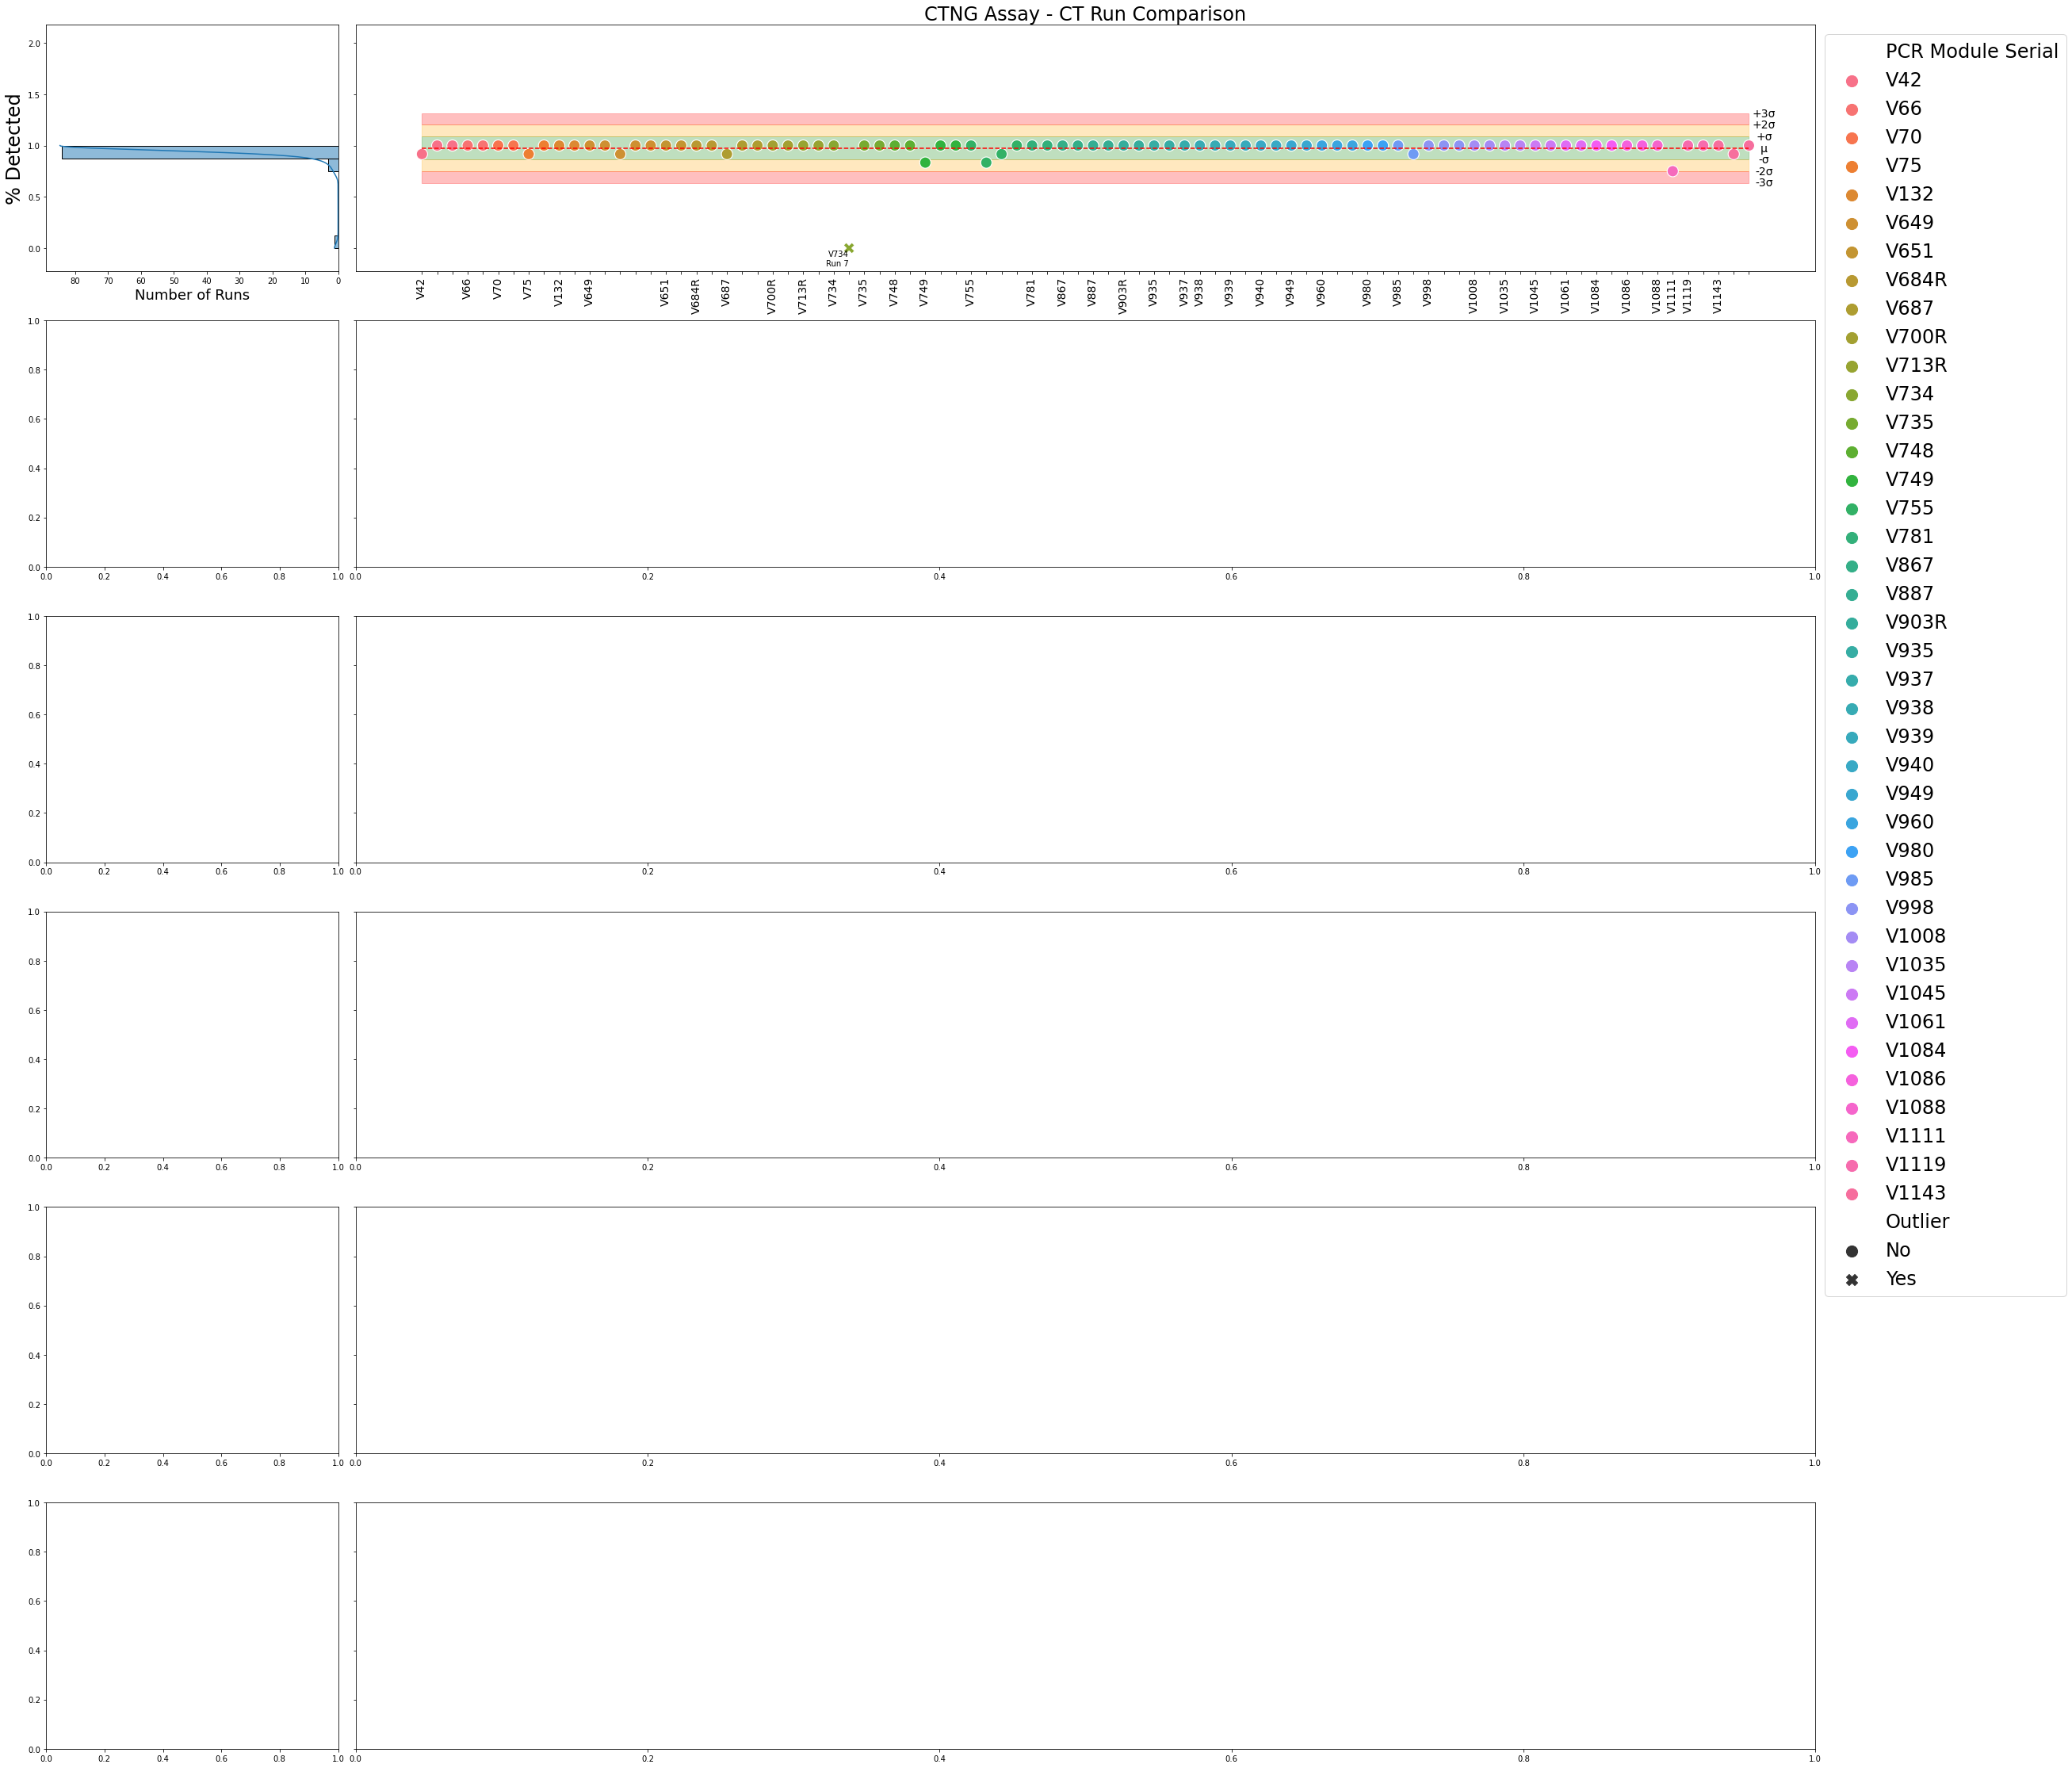

In [99]:
RunStats_agg.rename({'Target Amplified mean': '% Detected'},axis=1,inplace=True)
params_of_interest = ['Ct mean', 'Ct %CV','End Point Fluorescence mean','End Point Fluorescence %CV', 'Max Peak Height mean', 'Max Peak Height %CV', 'EPR mean', 'EPR %CV', 'Target Amplified mean', 'Sample Count']
params_of_interest = ['% Detected', 'Ct mean', 'Ct %CV','End Point Fluorescence mean','End Point Fluorescence %CV', 'Sample Count']

summaryFrame = pd.DataFrame(index=pd.MultiIndex.from_product([['drop'],['drop'],['drop']]),
                            columns=['mean', 'std', 'max', 'min'])


for assay in RunStats_agg.index.unique(0):
    
    RunStats_agg_assay = RunStats_agg.loc[assay, :]
    ##Determine Unique Targets for Each Assay:

    ##Determine Unique Targets for Each Assay:
    for target in RunStats_agg_assay.index.unique(0):
        RunStats_agg_target = RunStats_agg_assay.loc[target, :]

        
        fig, axs = plt.subplots(len(params_of_interest), 2, figsize=(40,40), sharey='row', gridspec_kw={'width_ratios': [1, 5]})
        plt.subplots_adjust(hspace=0.2, wspace=0.02)
        for param in params_of_interest:

            RunStats_agg_target_param = RunStats_agg_target[[param]].sort_index().reset_index()
            RunStats_agg_target_param['mod number'] = RunStats_agg_target_param['PCR Module Serial'].str.extract('(\d+)').astype(int)
            RunStats_agg_target_param.set_index(['mod number', 'Run Number'], inplace=True)
            RunStats_agg_target_param.sort_index(inplace=True)
            RunStats_agg_target_param.reset_index(inplace=True)
            RunStats_agg_target_param_mean = RunStats_agg_target_param[param].mean()
            RunStats_agg_target_param_std = RunStats_agg_target_param[param].std()
            RunStats_agg_target_param['Z-score'] = (RunStats_agg_target_param[param] - RunStats_agg_target_param_mean) / RunStats_agg_target_param_std
            RunStats_agg_target_param['Outlier'] = np.where(((RunStats_agg_target_param['Z-score']>2)|(RunStats_agg_target_param['Z-score']<-2)), 'Yes', 'No')

            RunStats_agg_target_param_min = RunStats_agg_target_param[param].min()
            RunStats_agg_target_param_max = RunStats_agg_target_param[param].max()


            RunStats_agg_target_param_range = RunStats_agg_target_param_max - RunStats_agg_target_param_min

            y_axis_upper = RunStats_agg_target_param_mean + (RunStats_agg_target_param_range*1.2) 
            y_axis_lower = RunStats_agg_target_param_mean - (RunStats_agg_target_param_range*1.2)



            label_offset = RunStats_agg_target_param_range*0.02
            
            summaryFrame.loc[(assay, target, param), 'mean'] = RunStats_agg_target_param_mean
            summaryFrame.loc[(assay, target, param), 'std'] = RunStats_agg_target_param_std
            summaryFrame.loc[(assay, target, param), 'min'] = RunStats_agg_target_param_min
            summaryFrame.loc[(assay, target, param), 'max'] = RunStats_agg_target_param_max

            X = np.arange(0, len(RunStats_agg_target_param))
            Y = RunStats_agg_target_param[param]

            mod_labels = []
            prev_mod = ''
            for idx in RunStats_agg_target_param.index:
                mod = RunStats_agg_target_param.loc[idx, 'PCR Module Serial']
                if mod == prev_mod:
                    mod_labels.append('')
                else:
                    mod_labels.append(mod)
                prev_mod = mod

            colors = RunStats_agg_target_param['PCR Module Serial']
            styles = RunStats_agg_target_param['Outlier']
            styleDict = {'Yes':'X','No':'o'}

            axs[params_of_interest.index(param),1].fill_between(X, RunStats_agg_target_param_mean-(RunStats_agg_target_param_std*1), RunStats_agg_target_param_mean+(RunStats_agg_target_param_std*1), color='green', alpha=0.25)
            axs[params_of_interest.index(param),1].fill_between(X, RunStats_agg_target_param_mean+(RunStats_agg_target_param_std*1), RunStats_agg_target_param_mean+(RunStats_agg_target_param_std*2), color='orange', alpha=0.25)
            axs[params_of_interest.index(param),1].fill_between(X, RunStats_agg_target_param_mean-(RunStats_agg_target_param_std*1), RunStats_agg_target_param_mean-(RunStats_agg_target_param_std*2), color='orange', alpha=0.25)
            axs[params_of_interest.index(param),1].fill_between(X, RunStats_agg_target_param_mean+(RunStats_agg_target_param_std*2), RunStats_agg_target_param_mean+(RunStats_agg_target_param_std*3), color='red', alpha=0.25)
            axs[params_of_interest.index(param),1].fill_between(X, RunStats_agg_target_param_mean-(RunStats_agg_target_param_std*2), RunStats_agg_target_param_mean-(RunStats_agg_target_param_std*3), color='red', alpha=0.25)
            
            sns.scatterplot(x=X, y=Y, ax=axs[params_of_interest.index(param),1], hue=colors, style=styles, markers=styleDict, s=200)
            sns.lineplot(x=[0, len(RunStats_agg_target_param)-1], y=[RunStats_agg_target_param_mean, RunStats_agg_target_param_mean],  ax=axs[params_of_interest.index(param),1], color='r', linestyle='--')
            sns.histplot(y=Y, ax=axs[params_of_interest.index(param),0], kde=True)
            axs[params_of_interest.index(param),0].set_ylabel(param, fontsize=24)
            axs[params_of_interest.index(param),0].set_xlabel('Number of Runs', fontsize=18)
            axs[params_of_interest.index(param),1].set_xticks(X)
            axs[params_of_interest.index(param),1].set_xticklabels(mod_labels, rotation=90,fontsize=14)
            
            x_min, x_max = axs[params_of_interest.index(param),0].get_xlim()
            axs[params_of_interest.index(param),0].set_xlim(x_max, x_min)

            axs[params_of_interest.index(param),1].set_ylim(y_axis_lower, y_axis_upper)
            
            
            axs[params_of_interest.index(param),1].annotate(xy=(len(X), RunStats_agg_target_param_mean-(RunStats_agg_target_param_std*1)),
                                                                text='-\u03C3', 
                                                                ha='center',
                                                                va='center',
                                                                rotation=0, fontsize=14)
            
            axs[params_of_interest.index(param),1].annotate(xy=(len(X), RunStats_agg_target_param_mean-(RunStats_agg_target_param_std*2)),
                                                                text='-2\u03C3', 
                                                                ha='center',
                                                                va='center',
                                                                rotation=0, fontsize=14)
            
            axs[params_of_interest.index(param),1].annotate(xy=(len(X), RunStats_agg_target_param_mean-(RunStats_agg_target_param_std*3)),
                                                                text='-3\u03C3', 
                                                                ha='center',
                                                                va='center',
                                                                rotation=0, fontsize=14)
            
            axs[params_of_interest.index(param),1].annotate(xy=(len(X), RunStats_agg_target_param_mean),
                                                                text='\u03BC', 
                                                                ha='center',
                                                                va='center',
                                                                rotation=0, fontsize=14)
            
            axs[params_of_interest.index(param),1].annotate(xy=(len(X), RunStats_agg_target_param_mean+(RunStats_agg_target_param_std*1)),
                                                                text='+\u03C3', 
                                                                ha='center',
                                                                va='center',
                                                                rotation=0, fontsize=14)
            
            axs[params_of_interest.index(param),1].annotate(xy=(len(X), RunStats_agg_target_param_mean+(RunStats_agg_target_param_std*2)),
                                                                text='+2\u03C3', 
                                                                ha='center',
                                                                va='center',
                                                                rotation=0, fontsize=14)
            
            axs[params_of_interest.index(param),1].annotate(xy=(len(X), RunStats_agg_target_param_mean+(RunStats_agg_target_param_std*3)),
                                                                text='+3\u03C3', 
                                                                ha='center',
                                                                va='center',
                                                                rotation=0, fontsize=14)
            i = 0
            outliers = []
            for idx in RunStats_agg_target_param[((RunStats_agg_target_param['Z-score']>2))].index:
                if RunStats_agg_target_param.loc[idx, 'PCR Module Serial'] not in outliers:
                    outliers.append(RunStats_agg_target_param.loc[idx, 'PCR Module Serial'])
            for module in outliers:
                mod_run_outliers = RunStats_agg_target_param.loc[((RunStats_agg_target_param['PCR Module Serial']==module)&
                                                                (RunStats_agg_target_param['Z-score']>2)),:]

                Xloc = mod_run_outliers.index.min()
                try:
                    if Xloc - prev_Xloc > 4:
                        i = 0
                except:
                    i = i 
                
                label = module+"\n"
                if i == 0:
                    align_var = 'right'
                    i = 1
                else:
                    align_var = 'left'
                    i = 0
                prev_Xloc = Xloc
                for x in mod_run_outliers.index:
                    label += " Run " + str(int(mod_run_outliers.loc[x, 'Run Number']))+"\n"# + " ("+str(mod_run_outliers.loc[x, 'Z-score'].round(2))+"\u03C3)\n"

                for x in mod_run_outliers.index:
                    Yloc = RunStats_agg_target_param.loc[idx, param]
                    XLocpoint = x
                
                    axs[params_of_interest.index(param),1].annotate(xy=(XLocpoint, RunStats_agg_target_param_max+label_offset),
                                                                xytext=(Xloc, RunStats_agg_target_param_max+label_offset),
                                                                text=label, 
                                                                ha=align_var,
                                                                va='bottom',
                                                                rotation=0)
            
                    

            i = 0 
            outliers = []
            for idx in RunStats_agg_target_param[((RunStats_agg_target_param['Z-score']<-2))].index:
                if RunStats_agg_target_param.loc[idx, 'PCR Module Serial'] not in outliers:
                    outliers.append(RunStats_agg_target_param.loc[idx, 'PCR Module Serial'])
            for module in outliers:
                mod_run_outliers = RunStats_agg_target_param.loc[((RunStats_agg_target_param['PCR Module Serial']==module)&
                                                                (RunStats_agg_target_param['Z-score']<-2)),:]
                Xloc = mod_run_outliers.index.min()
                try:
                    if Xloc - prev_Xloc > 4:
                        i = 0
                except:
                    i = i 
                label = module+"\n"
                if i == 0:
                    align_var = 'right'
                    i = 1
                else:
                    align_var = 'left'
                    i = 0
                prev_Xloc = Xloc
                for idx in mod_run_outliers.sort_values('Run Number').index:
                    label += " Run " + str(int(mod_run_outliers.loc[idx, 'Run Number']))+"\n"# + " ("+str(mod_run_outliers.loc[idx, 'Z-score'].round(2))+"\u03C3)\n"

                for idx in mod_run_outliers.index:
                    Yloc = RunStats_agg_target_param.loc[idx, param]
                    XLocpoint = idx
                
                    axs[params_of_interest.index(param),1].annotate(xy=(XLocpoint, RunStats_agg_target_param_min-label_offset),
                                                                xytext=(Xloc, RunStats_agg_target_param_min-label_offset),
                                                                text=label, 
                                                                ha=align_var,
                                                                va='top',
                                                                rotation=0,
                                                                )    
                
            
            
            legend = axs[0,1].legend(bbox_to_anchor=(1,0,0,1),ncol=1,fontsize=24)
            for handle in legend.legendHandles:
                handle.set_sizes([200])
            axs[0,1].set_title(assay+" Assay - "+target+" Run Comparison",fontsize=24)

            OutlierCounter = RunStats_agg_target_param[['PCR Module Serial', 'Outlier']].replace({'No':0,'Yes':1}).groupby('PCR Module Serial').agg(['sum', 'count'])
            OutlierCounter.columns = ['outliers', 'params_evaluted']
            for idx in OutlierCounter.index:
                mod_outliers = OutlierCounter.loc[idx, 'outliers']
                mod_params_evaluted = OutlierCounter.loc[idx, 'params_evaluted']
                ModPerformanceFrame.loc[idx, (assay, 'Outliers Detected')] += mod_outliers
                ModPerformanceFrame.loc[idx, (assay, 'Parameters Evaluated')] += mod_params_evaluted  

            
        for param in params_of_interest:
            
            idx = params_of_interest.index(param)

            if idx > 0:
                axs[idx,1].get_legend().remove()




    plt.show()

     
             
summaryFrame = summaryFrame.drop('drop')
summaryFrame['1\u03C3 start'] = summaryFrame['mean'] - summaryFrame['std']
summaryFrame['1\u03C3 end'] = summaryFrame['mean'] + summaryFrame['std']
summaryFrame['1\u03C3 range'] = summaryFrame['1\u03C3 end'] - summaryFrame['1\u03C3 start']

summaryFrame['2\u03C3 start'] = summaryFrame['mean'] - summaryFrame['std']*2
summaryFrame['2\u03C3 end'] = summaryFrame['mean'] + summaryFrame['std']*2
summaryFrame['2\u03C3 range'] = summaryFrame['2\u03C3 end'] - summaryFrame['2\u03C3 start']

summaryFrame['3\u03C3 start'] = summaryFrame['mean'] - summaryFrame['std']*3
summaryFrame['3\u03C3 end'] = summaryFrame['mean'] + summaryFrame['std']*3
summaryFrame['3\u03C3 range'] = summaryFrame['3\u03C3 end'] - summaryFrame['3\u03C3 start']

#summaryFrame

for param in ModPerformanceFrame.columns.unique(1):
    ModPerformanceFrame.loc[:, ('Total', param)] = ModPerformanceFrame.loc[:, [x for x in ModPerformanceFrame.columns if param in x]].sum(axis=1)
if 'All Modules' in ModPerformanceFrame.index.unique(0):
        print("drop it like it's hot")
        ModPerformanceFrame.drop('All Modules', inplace=True)
for assay, param in ModPerformanceFrame.columns:
    ModPerformanceFrame.loc['All Modules', (assay, '% Outlier')] = np.nan
    ModPerformanceFrame.loc['All Modules', (assay, param)] = ModPerformanceFrame.loc[:, (assay, param)].sum()
    ModPerformanceFrame.loc[:, (assay, '% Outlier')] = ModPerformanceFrame.loc[:, (assay, 'Outliers Detected')] / ModPerformanceFrame.loc[:, (assay, 'Parameters Evaluated')]
ModPerformanceFrame.loc[['V1143', 'V1088', 'V1263', 'V1178', 'V954']].sort_index(axis=1).sort_values(('Total', '% Outlier'),ascending=False)




In [ ]:
ModPerformanceFrame.sort_values(('Total', '% Outlier'),ascending=False)

In [ ]:
summaryFrame.loc[:,:].reset_index().style.hide_index()

In [ ]:
summaryFrame.loc[(slice(None), slice(None), 'End Point Fluorescence %CV'),:].style.format('{:.0%}')

In [ ]:
RunStats_agg.reset_index().style.hide_index()

In [ ]:
summaryFrame.loc[(slice(None), slice(None), 'Ct %CV'),:].style.format('{:.2%}')

In [ ]:
summaryFrame.loc[(slice(None), slice(None), 'End Point Fluorescence mean'),:].style.format('{:.2f}')


In [ ]:
def amplificationPlot(data, colField='Run Number', rowField='Channel', colorField='Pcr Cartridge Lane', plotwidth=20, plotheight=10, row_order=None, color_order=None, col_order=None, share_y_axis='row', title_color_field=None, title_colors=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.lines import Line2D
    """
    Plots amplification curves from input Data Frame on an array of subplots.
    Parameters
    ----------
    :param data: pandas.DataFrame
        Pandas Dataframe used as input.
    :param colField: str
        Field in data to use to define to which column to plot an amplification curve.
    :param rowField: str
        Field in data to use to define to which row to plot an amplification curve.
    :param colorField: str
        Field in data to use to define to which color to use when plotting an amplification curve.
    :param plotwidth int
        Width to use for figure that is returned.
    :param plotheight int
        Height to use for figure that is returned.
    :param roworder: list 
        Order / Values to plot when determining the row order.
    :param color_order: list 
        Order / Values to plot when determining the color order.
    :param col_order: list
        Order / Values to plot when determining the column order.
    :param share_y_axis: str, bool
        Options: "Row": Share across plot row, True: Share across entire plot.
    """
    ##Define Color Dictionary to use for PCR curves & other plots for up to 36 categories
    ColorDict36  = {1:'#FF0000',#Red 1
                2:'#00B050',#Green 2
                3:'#0070C0',#Blue 3
                4:'#7030A0',#Purple 4
                5:'#808080',#Light Grey 5
                6:'#FF6600',#Orange 6
                7:'#FFCC00',#Yellow 7
                8:'#9999FF',#Light Purple 8
                9:'#333333',#Black 9
                10:'#808000',#Goldish 10
                11:'#FF99CC',#Hot Pink 11
                12:'#003300',#Dark Green 12
                13:'#FF0000',#Red 1
                14:'#00B050',#Green 2
                15:'#0070C0',#Blue 3
                16:'#7030A0',#Purple 4
                17:'#808080',#Light Grey 5
                18:'#FF6600',#Orange 6
                19:'#FFCC00',#Yellow 7
                20:'#9999FF',#Light Purple 8
                21:'#333333',#Black 9
                22:'#808000',#Goldish 10
                23:'#FF99CC',#Hot Pink 11
                24:'#003300',#Dark Green 12  
                25:'#FF0000',#Red 1
                26:'#00B050',#Green 2
                27:'#0070C0',#Blue 3
                28:'#7030A0',#Purple 4
                29:'#808080',#Light Grey 5
                30:'#FF6600',#Orange 6
                31:'#FFCC00',#Yellow 7
                32:'#9999FF',#Light Purple 8
                33:'#333333',#Black 9
                34:'#808000',#Goldish 10
                35:'#FF99CC',#Hot Pink 11
                36:'#003300',#Dark Green 12  
                }

    styleDict36 = {1: 'solid',
                2: 'solid',
                3: 'solid',
                4: 'solid',
                5: 'solid',
                6: 'solid',
                7: 'solid',
                8: 'solid',
                9: 'solid',
                10: 'solid',
                11: 'solid',
                12: 'solid',
                13: 'dashed',
                14: 'dashed',
                15: 'dashed',
                16: 'dashed',
                17: 'dashed',
                18: 'dashed',
                19: 'dashed',
                20: 'dashed',
                21: 'dashed',
                22: 'dashed',
                23: 'dashed',
                24: 'dashed',
                25: 'dashdot',
                26: 'dashdot',
                27: 'dashdot',
                28: 'dashdot',
                29: 'dashdot',
                30: 'dashdot',
                31: 'dashdot',
                32: 'dashdot',
                33: 'dashdot',
                34: 'dashdot',
                35: 'dashdot',
                36: 'dashdot'}

    if title_color_field != None:
        plotFrame = data.reset_index()[[colField, rowField, colorField, title_color_field]+["Readings "+str(i) for i in range(1,51)]]
    else:
        plotFrame = data.reset_index()[[colField, rowField, colorField]+["Readings "+str(i) for i in range(1,51)]]
    plotFrame.loc[:, [colField, rowField, colorField]] = plotFrame.loc[:, [colField, rowField, colorField]].fillna('')
    col_groups = sorted(plotFrame[colField].unique().tolist())
    

    if col_order == None:
        col_groups = sorted(plotFrame[colField].unique().tolist())
    else:
        col_groups = col_order
        plotFrame = plotFrame[plotFrame[colField].isin(col_groups)]

    if row_order == None:
        row_groups = sorted(plotFrame[rowField].unique().tolist())
    else:
        row_groups = row_order
        plotFrame = plotFrame[plotFrame[rowField].isin(row_groups)]

    if color_order == None:
        color_groups = sorted(plotFrame[colorField].unique().tolist())
    else:
        color_groups = color_order
        plotFrame = plotFrame[plotFrame[colorField].isin(color_groups)]

    fig, axs = plt.subplots(len(row_groups), len(col_groups)+1, figsize=(plotwidth, plotheight),sharey=share_y_axis, sharex="col")

    for idx in plotFrame.index:
        X = np.arange(1,51,1)
        Y = plotFrame.loc[idx, ["Readings "+str(i) for i in range(1,51)]]
        col = plotFrame.loc[idx, colField]
        row = plotFrame.loc[idx, rowField]
        
        color = plotFrame.loc[idx, colorField]
        sns.lineplot(x=X, y=Y, color=ColorDict36[color_groups.index(color)+1], linestyle=styleDict36[color_groups.index(color)+1], ax=axs[row_groups.index(row), col_groups.index(col)])

    for col_idx in range(0,len(col_groups)):
        
        
        if title_color_field != None:
        
            if title_colors != None:
                
                #try:
                titleColor = plotFrame.loc[plotFrame[colField]==col_groups[col_idx], title_color_field].values[0]
                print(titleColor)
                axs[0, col_idx].set_title(col_groups[col_idx], fontsize=12, color=title_colors[titleColor])
                #except:
                #print("error in coloring title.")

            else:
                print("please supply colorDict for title colors")
        else:
            axs[0, col_idx].set_title(col_groups[col_idx], fontsize=12)
            

    for row_idx in range(0, len(row_groups)):
        axs[row_idx, 0].set_ylabel(row_groups[row_idx],fontsize=12)
        axs[row_idx,len(col_groups)].axis('Off')

    legend_elements = []
    for color in color_groups:
        newLabel = Line2D([0], [0], color=ColorDict36[color_groups.index(color)+1], linestyle=styleDict36[color_groups.index(color)+1], lw=3,label=color)
        legend_elements.append(newLabel)

    axs[0, len(col_groups)].legend(handles=legend_elements, fontsize=12, loc='upper left', ncol=1, title=colorField)

            
    
    return fig


In [ ]:
BoydFrame['Mod Serial Number'] = BoydFrame['PCR Module Serial'].str.extract('(\d+)').astype(int)
BoydFrame['Mod / Run'] = BoydFrame['PCR Module Serial'] + " Run " + BoydFrame['Run Number'].astype(int).astype(str)

mod_status = pd.read_csv('mod_status_flat.csv')
BoydFrame = BoydFrame.set_index('PCR Module Serial').join(mod_status.set_index('PCR Module Serial')).reset_index()

BoydFrame['4plex V2 Qualified?'] = BoydFrame['4plex V2 Qualified?'].str.upper()
BoydFrame['4plex V2 Qualified?'].fillna('', inplace=True)
BoydFrame['4plex V2 Qualified?'].unique()

BoydFrame['HCV Qualified? '] = BoydFrame['HCV Qualified? '].str.upper()
BoydFrame['HCV Qualified? '].fillna('', inplace=True)
BoydFrame['HCV Qualified? '].unique()

BoydFrame['CTNG Qualified?'] = BoydFrame['CTNG Qualified?'].str.upper()
BoydFrame['CTNG Qualified?'].fillna('', inplace=True)
BoydFrame['CTNG Qualified?'].unique()

In [ ]:
data_input = BoydFrame.loc[((BoydFrame['Processing Step']=='Normalized')&
                                 (BoydFrame['Result Code']=='FRS1')), :].sort_values(['Mod Serial Number', 'Run Number'])

amplificationPlot(data_input,
                  colField='Mod / Run',
                  plotwidth=3*len([x for x in data_input['Mod / Run'].unique()]),
                  col_order=[x for x in data_input['Mod / Run'].unique()],
                  row_order=['Green', 'Yellow', 'Orange', 'Far_Red', 'Red'],
                  title_color_field='4plex V2 Qualified?',
                  title_colors={'YES':'#00B050', 'NO':'#FF0000', 'ONE MORE':'#FF6600', '':'k'}) 

In [ ]:
BoydFrame['HCV Qualified? '].unique()

In [ ]:
data_input = BoydFrame.loc[((BoydFrame['Processing Step']=='Normalized')&
                                 (BoydFrame['Result Code']=='HCV')), :].sort_values(['Mod Serial Number', 'Run Number'])

amplificationPlot(data_input,
                  colField='Mod / Run',
                  plotwidth=3*len([x for x in data_input['Mod / Run'].unique()]),
                  col_order=[x for x in data_input['Mod / Run'].unique()],
                  plotheight=5,
                  row_order=['Green', 'Yellow'],
                  title_color_field='HCV Qualified? ',
                  title_colors={'YES':'#00B050', 'NO':'#FF0000', 'MOD CAL OR SWAP':'#FF0000', '':'k'}) 


In [ ]:
data_input = BoydFrame.loc[((BoydFrame['Processing Step']=='Normalized')&
                                 (BoydFrame['Result Code']=='CTNG')), :].sort_values(['Mod Serial Number', 'Run Number'])

amplificationPlot(data_input,
                  colField='Mod / Run',
                  plotwidth=3*len([x for x in data_input['Mod / Run'].unique()]),
                  col_order=[x for x in data_input['Mod / Run'].unique()],
                  plotheight=7,
                  row_order=['Orange', 'Green', 'Yellow'],
                  title_color_field='CTNG Qualified?',
                  title_colors={'YES':'#00B050', 'NO':'#FF0000', 'TWO MORE':'#FF6600', '':'k'}) 

In [ ]:
HTML(BoydFrame[['PCR Module Serial', 'Run Number', 'Result Code', 'File Source']].groupby(['PCR Module Serial', 'Run Number', 'Result Code']).agg(['unique']).reset_index().style.hide_index().to_html())

In [ ]:
BoydFrame.columns

In [ ]:
sorted(BoydFrame['PCR Module Serial'].unique())